In [1]:
!pip install casadi
from IPython.display import clear_output
import os
import time

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

In [2]:
m = 1
# J = 2.5 * 1e-4
J = 1e-1
l = 0.086
g = 9.81

nx = 6 #状態変数の次元
nu = 2 #制御変数の次元

# 後退ホライズン等
T = 1
K = 20
dt = T/K

#コスト行列
Q = casadi.diag([10,10,10,10,10,10])
Q_f = casadi.diag([10,10,10,10,10,10])
R = casadi.diag([0.1,0.1])

# 制約条件
x_lb = [-10,-10,-np.pi/2,-10,-10,-10]
x_ub = [10,10,np.pi/2,10,10,10]
u_lb = [0,0]
u_ub = [10,10]

#目標値
x_ref = casadi.DM([3,3,0,0,0,0])
u_ref = casadi.DM([m*g/2,m*g/2])

total = nx*(K+1) + nu*K

In [3]:
def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    x = states[0]
    y = states[1]
    theta = states[2]
    x_dot = states[3]
    y_dot = states[4]
    theta_dot = states[5]
    f1 = ctrls[0]
    f2 = ctrls[1]

    x_ddot = -g*theta
    y_ddot = (f1+f2)/m -g
    theta_ddot = (f1-f2)*l/J

    states_dot = casadi.vertcat(x_dot,y_dot,theta_dot,x_ddot,y_ddot,theta_ddot)

    f = casadi.Function("f",[states,ctrls],[states_dot],['x','u'],['x_dot'])
    return f

def make_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    r1 = f(x=states,u=ctrls)["x_dot"]
    r2 = f(x=states+dt*r1/2,u=ctrls)["x_dot"]
    r3 = f(x=states+dt*r2/2,u=ctrls)["x_dot"]
    r4 = f(x=states+dt*r3,u=ctrls)["x_dot"]

    states_next = states + dt*(r1+2*r2+2*r3+r4)/6

    RK4 = casadi.Function("RK4",[states,ctrls],[states_next],["x","u"],["x_next"])
    return RK4

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]

    dae = {"x":states,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(x,u):
    x_diff = x - x_ref
    u_diff = u - u_ref
    cost = (casadi.dot(Q@x_diff,x_diff) + casadi.dot(R@u_diff,u_diff)) / 2
    return cost

def compute_final_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

In [4]:
def make_qps():
    RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k]) * dt
        eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_final_cost(X[-1])

    qp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}

    S_osqp = casadi.qpsol("S","osqp",qp)

    option_qpoases = {"printLevel":"none"}
    S_qpoases = casadi.qpsol("S","qpoases",qp,option_qpoases)

    option_ipqp = {
        "linear_solver":"qr",
        "print_header":False,
        "print_info":False,
        "print_iter":False}
    S_ipqp = casadi.qpsol("S","ipqp",qp,option_ipqp)
    return S_osqp, S_qpoases, S_ipqp

In [5]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [6]:
S_osqp, S_qpoases, S_ipqp = make_qps()


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.



[*] solver: osqp, elapsed time: 0.156279s


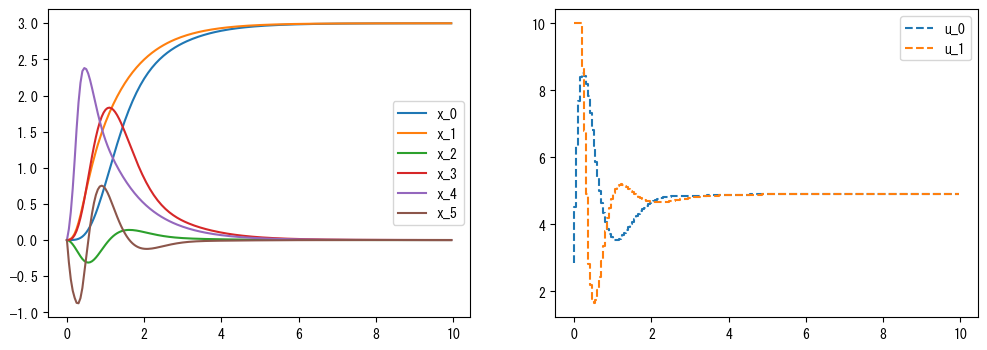

In [7]:
t_span = [0,10]
t_eval = np.arange(*t_span,dt)
I = make_integrator()

x_init = casadi.DM([0,0,0,0,0,0]) # 初期値
x0 = casadi.DM.zeros(total)

x0 = [x_init]
x_tmp = x_init
for i in range(K):
    x_tmp = I(x0=x_tmp)["xf"]
    x0.append(x_tmp)
u0 = casadi.DM.zeros(nu*K)
x0 = casadi.vertcat(*x0,u0)

start_time = time.perf_counter()
X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S_osqp,x_current,x0)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)
end_time = time.perf_counter()
print(f"[*] solver: osqp, elapsed time: {end_time-start_time:1f}s")

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

plt.savefig("images/chap7_2d_quad_mpc_osqp.png")
plt.show()

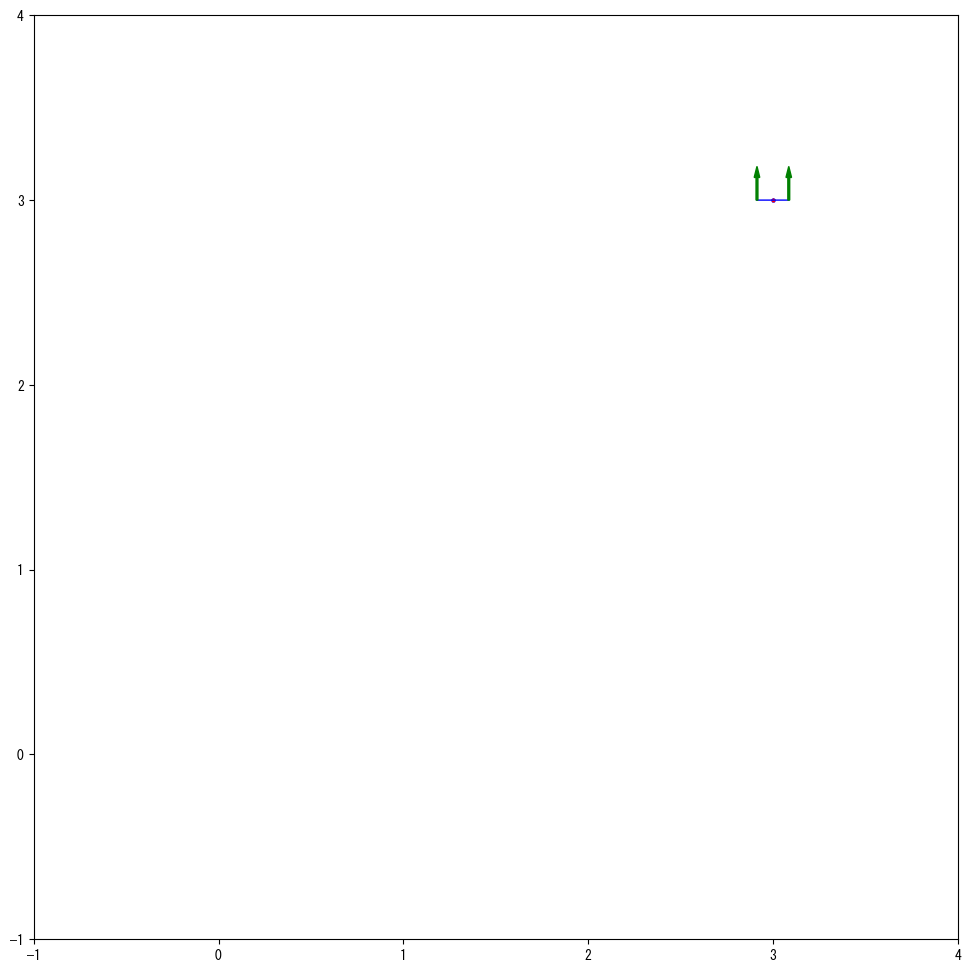

In [8]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
frames = np.arange(0,t_eval.size)
fps = 1 / dt

def update_figure(i):
    x_lim_min = -1
    x_lim_max = 4
    y_lim_min = -1
    y_lim_max = 4
    u_scale = 40

    ax.cla()
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.set_ylim(y_lim_min, y_lim_max)
    ax.set_aspect("equal")

    x,y,theta,_,_,_ = X[i]
    f1,f2 = U[i]

    center = np.array([x,y])
    left = center - l*np.array([np.cos(theta),np.sin(theta)])
    right = center + l*np.array([np.cos(theta),np.sin(theta)])
    points = np.stack([left,right],axis=0)
    ref = x_ref[:2].full().ravel()
    
    left_f = f2*np.array([-np.sin(theta),np.cos(theta)])
    right_f = f1*np.array([-np.sin(theta),np.cos(theta)])

    ax.scatter(*center,color="blue",s=5)
    ax.scatter(*ref,color="red",s=5,marker="*")
    ax.plot(*points.T, color='blue', lw=1)

    ax.arrow(*left,*left_f/u_scale,width=0.01,head_width=0.03,head_length=0.06,length_includes_head=False,color="green",zorder=3)
    ax.arrow(*right,*right_f/u_scale,width=0.01,head_width=0.03,head_length=0.06,length_includes_head=False,color="green",zorder=3)

ani = FuncAnimation(fig, update_figure, frames=frames)
ani.save("images/chap7_2d_quadrotor.gif",writer="pillow",fps=fps)


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

[*] solver: qpoases, elapsed time: 1.635075s


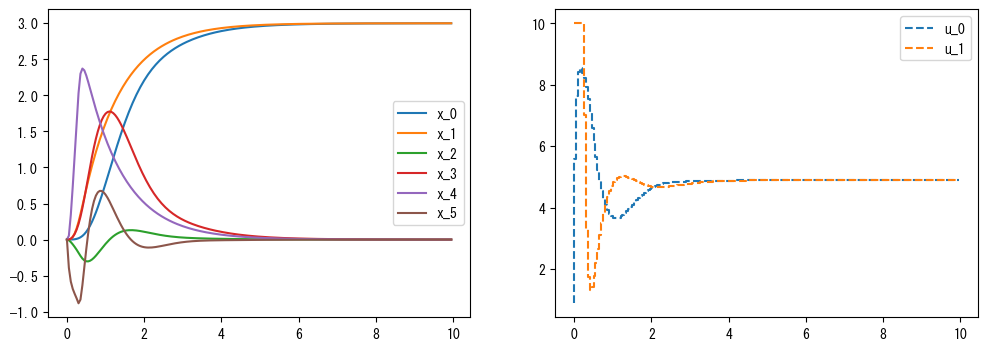

In [9]:
t_span = [0,10]
t_eval = np.arange(*t_span,dt)
I = make_integrator()

x_init = casadi.DM([0,0,0,0,0,0]) # 初期値
x0 = casadi.DM.zeros(total)

x0 = [x_init]
x_tmp = x_init
for i in range(K):
    x_tmp = I(x0=x_tmp)["xf"]
    x0.append(x_tmp)
u0 = casadi.DM.zeros(nu*K)
x0 = casadi.vertcat(*x0,u0)

start_time = time.perf_counter()
X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S_qpoases,x_current,x0)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)
end_time = time.perf_counter()
print(f"[*] solver: qpoases, elapsed time: {end_time-start_time:1f}s")

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

plt.savefig("images/chap7_2d_quad_mpc_qpoases.png")
plt.show()

In [10]:
t_span = [0,10]
t_eval = np.arange(*t_span,dt)
I = make_integrator()

x_init = casadi.DM([0,0,0,0,0,0]) # 初期値
x0 = casadi.DM.zeros(total)

x0 = [x_init]
x_tmp = x_init
for i in range(K):
    x_tmp = I(x0=x_tmp)["xf"]
    x0.append(x_tmp)
u0 = casadi.DM.zeros(nu*K)
x0 = casadi.vertcat(*x0,u0)

start_time = time.perf_counter()
X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S_ipqp,x_current,x0)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)
end_time = time.perf_counter()
print(f"[*] solver: ipqp, elapsed time: {end_time-start_time:1f}s")

[*] solver: ipqp, elapsed time: 0.149518s


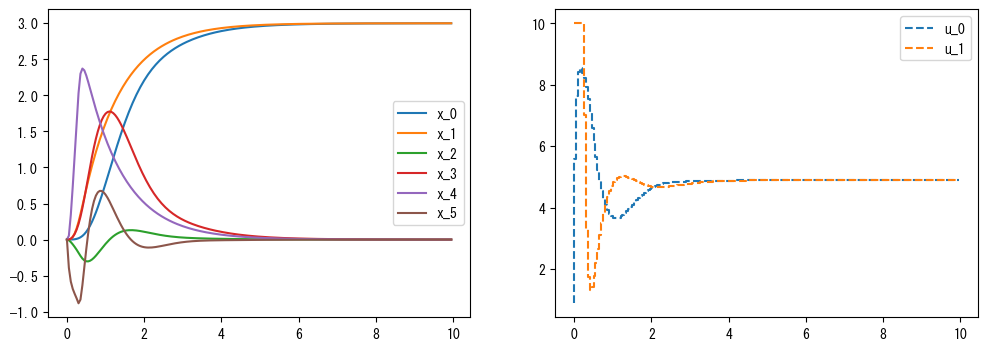

In [11]:
X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

plt.savefig("images/chap7_2d_quad_mpc_ipqp.png")
plt.show()

In [12]:
# import os
# import shutil
# import glob
# import natsort
# import cv2
# shutil.rmtree("./tmp",ignore_errors=True)
# os.mkdir("./tmp")
# for i in np.linspace(0,99,12):
#     i = int(i)
#     update_figure(i)
#     fig.savefig(f"./tmp/_frame_{i}.png")
# paths = glob.glob("./tmp/*.png")
# paths = natsort.natsorted(paths)
# paths = [cv2.imread(path) for path in paths]
# paths = np.stack(paths,axis=0)
# paths = paths.reshape((4,3) + paths[0].shape)
# paths = np.concatenate(paths,axis=1)
# paths = np.concatenate(paths,axis=1)
# cv2.imwrite("images/chap7_2d_quadrotor_mpc_anim.png",paths)
# shutil.rmtree("./tmp",ignore_errors=True)